In [127]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.constants import e, m_e, m_p, c

In [128]:
filename = "results/electrons/electron_trajectory_1.0e+07_90"
Re = 6378137
pitch_angle = filename.split("_")[-1]

In [129]:
K = (1e7 * e)  # Kinetic energy in Joules
v_mod = (c / np.sqrt(1 + (m_e * c**2) / K))/c  # Speed
c2 = c**2

In [130]:
B0 = 3.07e-5  # Magnetic field in Tesla
print(4*Re*((B0*e)/(m_e*c)))
print(4*Re)

459507.81870879815
25512548


In [131]:
# Load the data
data = pd.read_csv(f'{filename}.csv')
data

,t,x,y,z,vx,vy,vz
0,0.000,2.551255e+07,0.000000e+00,0.000000e+00,0.000000e+00,2.924144e+08,1.790522e-08
1,0.004,2.550720e+07,-1.071730e+04,7.173000e-11,2.197222e+08,1.929465e+08,1.968431e-08
2,0.008,2.549480e+07,-1.339514e+04,1.425712e-10,2.899175e+08,-3.813190e+07,2.246820e-08
3,0.012,2.548379e+07,-5.446565e+03,2.118908e-10,1.619937e+08,-2.434426e+08,2.124883e-08
4,0.016,2.548172e+07,8.449845e+03,2.793207e-10,-7.705833e+07,-2.820785e+08,1.408804e-08
...,...,...,...,...,...,...,...
4995,19.980,2.493398e+07,5.403784e+06,4.518486e-10,-5.847999e+07,2.867525e+08,-1.397669e-08
4996,19.984,2.491355e+07,5.386370e+06,3.918216e-10,2.805538e+08,-8.328559e+07,-3.371864e-09
4997,19.988,2.490655e+07,5.413999e+06,3.293061e-10,-2.065278e+08,-2.073481e+08,-2.559818e-08
4998,19.992,2.493290e+07,5.408489e+06,2.644705e-10,-8.562971e+07,2.798474e+08,-1.748110e-08


In [132]:
def Bfield(data):
    B0_Re3 = 3.07e-5 * (6378137**3) 
    Bx = np.zeros(len(data["t"]))
    By = np.zeros(len(data["t"]))
    Bz = np.zeros(len(data["t"]))
    
    # Precompute shared terms
    r2 = data["x"]**2 + data["y"]**2 + data["z"]**2
    r5 = r2**2.5
    v2 = data["vx"]**2 + data["vy"]**2 + data["vz"]**2
    gamma = 1 / np.sqrt(1 - v2 / c2)

    # Magnetic field components
    B_factor = -B0_Re3 / r5
    Bx = 3 * data["x"] * data["z"] * B_factor
    By = 3 * data["y"] * data["z"] * B_factor
    Bz = (2 * data["z"]**2 - data["x"]**2 - data["y"]**2) * B_factor
    return Bx, By, Bz
    

In [133]:
Bx, By, Bz = Bfield(data)
B = np.sqrt(Bx**2 + By**2 + Bz**2)

#add the magnetic field to the data
data["Bx"] = Bx
data["By"] = By
data["Bz"] = Bz

In [134]:
# plot the data in 3D with plotly
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=data["x"] / Re, y=data["y"]/ Re, z=data["z"] / Re, mode='lines', name='Trajectory'))
fig.update_layout(title='Proton trajectory', scene=dict(aspectmode='cube'), scene_aspectmode='cube')
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))
fig.update_layout(scene=dict(xaxis=dict(range=[-5, 5]), yaxis=dict(range=[-5, 5]), zaxis=dict(range=[-5, 5])))
#add sphere in the center of the earth
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
fig.add_trace(go.Surface(x=x, y=y, z=z, colorscale='earth', showscale=False))
fig.write_html(f"{filename}.html")

In [135]:
m = m_e
v_mod_1 = c / np.sqrt(1 + (m * c**2) / K)  # Speed
v_mod_2 = c *np.sqrt(1- (m*c**2/(m*c**2 + K))**2)

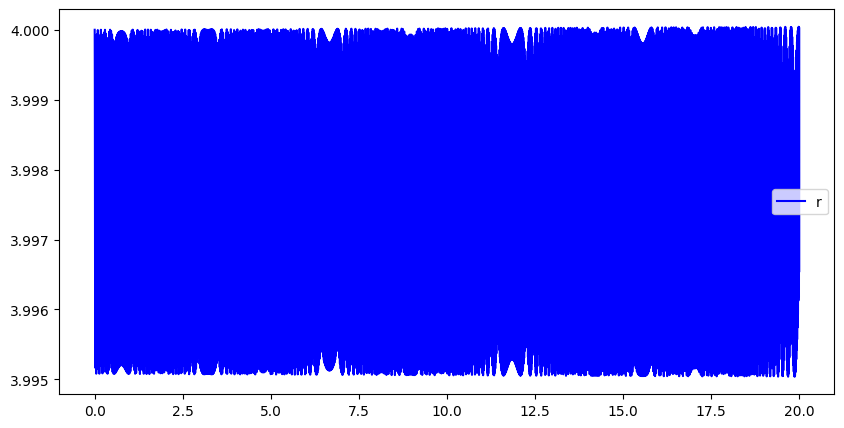

In [136]:
plt.figure(figsize=(10, 5))
plt.plot(data["t"], np.sqrt(data["x"]**2 + data["y"]**2 + data["z"]**2)/Re, label="r", color="blue")
plt.legend()
plt.show()

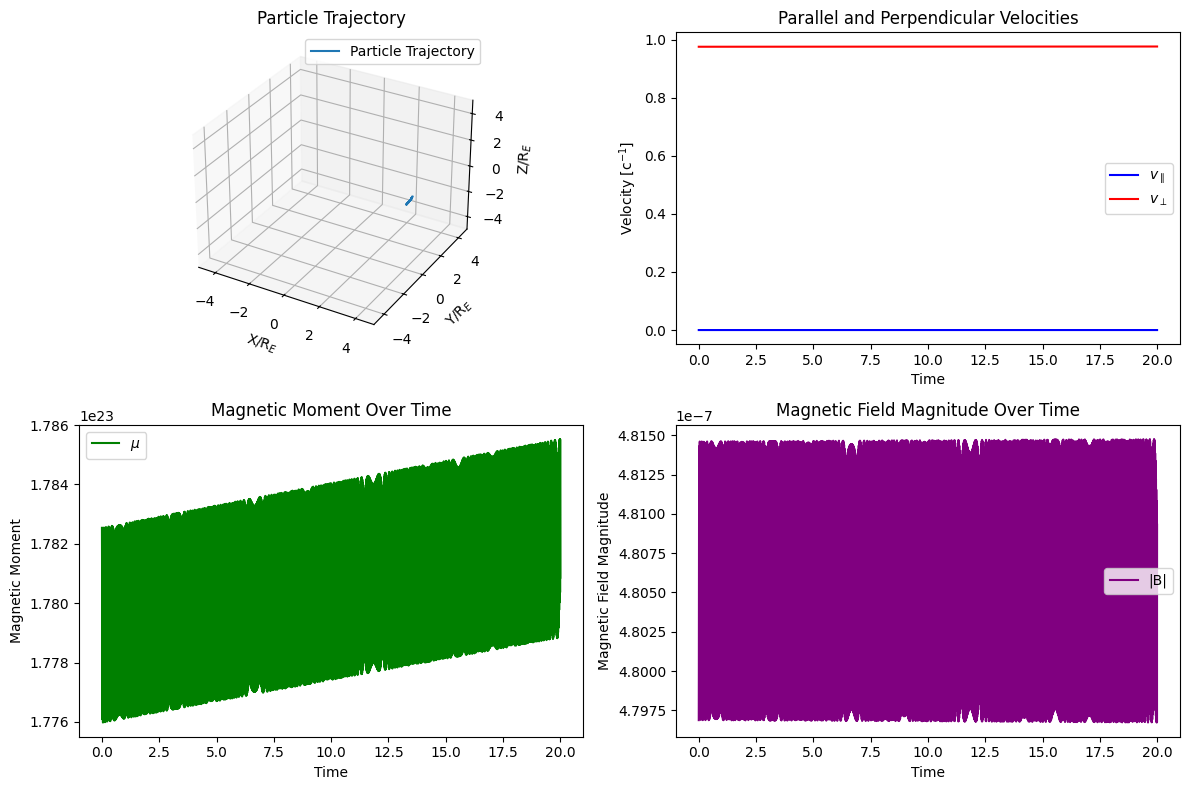

Turning points: 155
Max distance: 4.0000427988640155
Escaped: False
mu_variation: 0.0013998593603776405
Significant variation: False


'Confined'

In [137]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_particle_confinement(t, x, y, z, vx, vy, vz, Bx, By, Bz):
    """
    Analyze particle confinement in a magnetic field.

    Parameters:
    t  : array-like
        Time steps.
    x, y, z : array-like
        Particle positions over time.
    vx, vy, vz : array-like
        Particle velocities over time.
    Bx, By, Bz : array-like
        Magnetic field components over time.
    """
    # Compute magnetic field magnitude
    B_magnitude = np.sqrt(Bx**2 + By**2 + Bz**2)
    
    # Compute velocity magnitude
    v_magnitude = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # Compute dot product v · B
    v_dot_B = vx * Bx + vy * By + vz * Bz
    
    # Parallel velocity
    v_parallel = v_dot_B / B_magnitude
    
    # Perpendicular velocity
    v_perpendicular = np.sqrt(v_magnitude**2 - v_parallel**2)
    
    # Magnetic moment (normalized units: μ = v_perp^2 / B)
    magnetic_moment = v_perpendicular**2 / B_magnitude
    
    # Plot particle trajectory
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.plot(x/Re, y/Re, z/Re, label='Particle Trajectory')
    ax1.set_xlabel(r'X/R$_E$')
    ax1.set_ylabel(r'Y/R$_E$')
    ax1.set_zlabel(r'Z/R$_E$')
    ax1.set_xlim(-5, 5)
    ax1.set_ylim(-5, 5)
    ax1.set_zlim(-5, 5)
    ax1.set_title('Particle Trajectory')
    ax1.legend()
    
    # Plot v_parallel and v_perpendicular
    ax2 = fig.add_subplot(222)
    ax2.plot(t, v_parallel/c, label=r'$v_\parallel$', color='blue')
    ax2.plot(t, v_perpendicular/c, label=r'$v_\perp$', color='red')
    ax2.set_xlabel('Time')
    ax2.set_ylabel(r'Velocity [c$^{-1}$]')
    ax2.set_title('Parallel and Perpendicular Velocities')
    ax2.legend()
    
    # Plot the average magnetic moment
    ax3 = fig.add_subplot(223)
    ax3.plot(t, magnetic_moment, label=r'$\mu$', color='green')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Magnetic Moment')
    ax3.set_title('Magnetic Moment Over Time')
    ax3.legend()
    
    # Plot magnetic field magnitude
    ax4 = fig.add_subplot(224)
    ax4.plot(t, B_magnitude, label='|B|', color='purple')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Magnetic Field Magnitude')
    ax4.set_title('Magnetic Field Magnitude Over Time')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # compute turning points by finding sign changes in v_parallel
    turning_points = np.where(np.diff(np.sign(v_parallel)))[0]
    print(f"Turning points: {len(turning_points)}")
    
    # Check if the particle stays within a certain distance
    max_distance = (np.sqrt(x**2 + y**2 + z**2).max())/Re
    confinement_radius = 10  # Example threshold in normalized units
    escaped = max_distance > confinement_radius
    print(f"Max distance: {max_distance}\nEscaped: {escaped}")
    
    # Check magnetic moment consistency
    mu_variation = np.std(magnetic_moment) / np.mean(magnetic_moment)
    print(f"mu_variation: {mu_variation}")
    significant_variation = mu_variation > 0.1  # Example threshold
    print(f"Significant variation: {significant_variation}")

    # Classification
    if len(turning_points) > 1 and not escaped and not significant_variation:
        return "Confined"
    else:
        return "Not Confined"

# Call the analysis function
analyze_particle_confinement(data["t"], data["x"], data["y"], data["z"], data["vx"], data["vy"], data["vz"], data["Bx"], data["By"], data["Bz"])
